Les durées sont indicatives et dépendent évidemment de chaque personne.Si vous voyez que vous ne pouvez pas terminer un exercice à temps, n'hésitez pas à passer à l'exercice suivant.

Si vous n'avez pas le temps de tout terminer, vous pouvez recommencer ce week-end ou la semaine prochaine.Vous indiquerez simplement dans les commentaires les scripts que vous avez terminés par la suite.

In [ ]:
import json
import requests
import folium
import seaborn as sns
import nltk
import spacy
from spacy.lang.fr.examples import sentences
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('popular')
nltk.corpus.stopwords.words("english")
nltk.corpus.stopwords.words("french")
nltk.download('punkt_tab')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

# Partie 1 - API - Vers 1h

L'ensemble de données suivant répertorie une sélection des meilleurs restaurants de Paris, à des prix très abordables (moins de 15 euros par menu en moyenne).

In [ ]:
import pandas as pd

food_paris = pd.read_csv("https://raw.githubusercontent.com/WildCodeSchool/wilddata/main/food.csv").drop(columns = "Unnamed: 0")

Utilisez cette [API](https://adresse.data.gouv.fr/api-doc/adresse), pour récupérer des points de coordonnées (lon, lat).

In [ ]:
def recherche(adresse, code_postal):

    url = 'https://api-adresse.data.gouv.fr/search/?q='
    lien = url + adresse.replace(' ','+') + '&postcode=' + code_postal[:5]
    r = requests.get(lien).json()
    resultat = r['features'][0]['geometry']['coordinates'][::-1]

    return resultat

Mettez ces coordonnées dans une colonnes dans votre DataFrame `food_paris`

In [ ]:
food_paris['coordonnées'] = food_paris.apply(lambda x : recherche(x['adresse'], x['code postal']), axis = 1)

In [ ]:
food_paris['coordonnées'].head()

,coordonnées
0,"[48.864374, 2.336258]"
1,"[48.86355, 2.344247]"
2,"[48.865983, 2.344484]"
3,"[48.867596, 2.343757]"
4,"[48.869951, 2.34794]"


# Folium

Affichez maintenant ces restaurants sur une carte, en utilisant la bibliothèque `folium`.

In [ ]:
m = folium.Map(location=food_paris['coordonnées'].iloc[0],zoom_start=13)

for n in range(len(food_paris)):
    point = food_paris['coordonnées'].iloc[n]

    folium.Marker(
        location=point,
        popup= food_paris['nom'].iloc[n]
        ).add_to(m)

m

# Tri et regroupement

Afficher un classement descendant, compte tenu du nombre de restaurants par code postal.

In [ ]:
classement_postal = food_paris[['code postal', 'nom']].groupby('code postal').count().reset_index().sort_values(by = 'nom', ascending = False)

In [ ]:
classement_postal

,code postal,nom
1,75002 Paris,5
7,75009 Paris,4
8,75010 Paris,4
9,75011 Paris,3
0,75001 Paris,2
2,75003 Paris,2
3,75004 Paris,2
4,75006 Paris,2
6,75008 Paris,2
5,75007 Paris,1


# Partie 2 - Exploration et traitement des données - Python & Pandas - environ 30 min

Exécutez le code ci-dessous.Vous obtiendrez un DataFrame avec 10 000 commentaires de restaurant.
- Date: la date du commentaire
- Stars: La note (de 1 à 5)
- Texte: le texte du commentaire
- Utile: le nombre d'utilisateurs qui ont indiqué ce commentaire comme "utile"
- Sentiment: le mot "bon" ou "mauvais" selon la note des étoiles

L'objectif de ces pièces sera d'explorer cet ensemble de données, puis de proposer un modèle de prédiction de notation positive selon les autres fonctionnalités.

Commencez par vérifier qu'il n'y a pas de valeurs manquantes.

In [ ]:
import pandas as pd
df_restaurants = pd.read_csv("https://github.com/WildCodeSchool/wilddata/raw/main/restaurant.zip", index_col='Unnamed: 0').loc[:,["date", "stars", "text", "useful"]]
df_restaurants["sentiment"] = df_restaurants["stars"].apply(lambda x: "bad" if x <=3 else "good")
df_restaurants

,date,stars,text,useful,sentiment
0,2011-01-26,5,My wife took me here on my birthday for breakf...,5,good
1,2011-07-27,5,I have no idea why some people give bad review...,0,good
2,2012-06-14,4,love the gyro plate. Rice is so good and I als...,1,good
3,2010-05-27,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",2,good
4,2012-01-05,5,General Manager Scott Petello is a good egg!!!...,0,good
...,...,...,...,...,...
9995,2012-07-28,3,First visit...Had lunch here today - used my G...,2,bad
9996,2012-01-18,4,Should be called house of deliciousness!\n\nI ...,0,good
9997,2010-11-16,4,I recently visited Olive and Ivy for business ...,0,good
9998,2012-12-02,2,My nephew just moved to Scottsdale recently so...,0,bad


In [ ]:
df_restaurants.isna().value_counts()

,,,,,count
date,stars,text,useful,sentiment,
False,False,False,False,False,10000


## colonne "texte"

Utilisez **Apply** pour créer une nouvelle colonne `len_text`, indiquant la longueur (nombre de caractères) de chaque commentaire.

Afficher un histogramme et un `boxplot` pour représenter la distribution de cette colonne `len_text`.Les valeurs sont-elles bien distribuées?La plupart des commentaires sont-ils longs ou courts?

In [ ]:
df_restaurants['len_text'] = df_restaurants['text'].apply(lambda x : len(x))

In [ ]:
df_restaurants['len_text']

,len_text
0,889
1,1345
2,76
3,419
4,469
...,...
9995,668
9996,881
9997,1425
9998,880


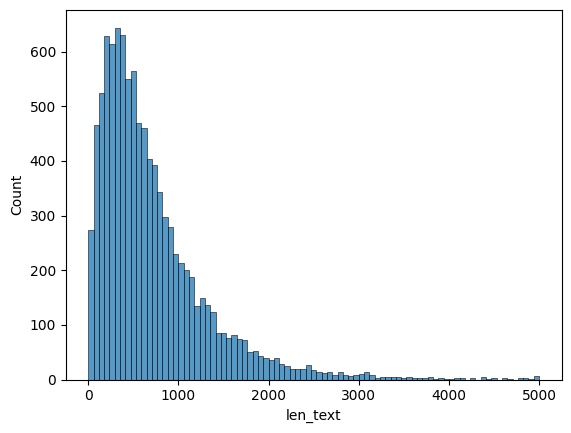

In [ ]:
sns.histplot(df_restaurants['len_text']);

In [ ]:
'''
Les valeurs ne sont pas forcément bien distribuées, il existe davantage de commentaires courts.
'''

'\nLes valeurs ne sont pas forcément bien distribuées, il existe davantage de commentaires courts.\n'

## Colonne "Stars"

- Afficher un diagramme de dispersion pour comparer la colonne `utile` et la colonne `stars`.Pensez-vous qu'il y a une corrélation?Veuillez calculer le coefficient de corrélation.

- Idem entre `len_text` et `utile`.

- Veuillez commenter et interpréter les résultats.

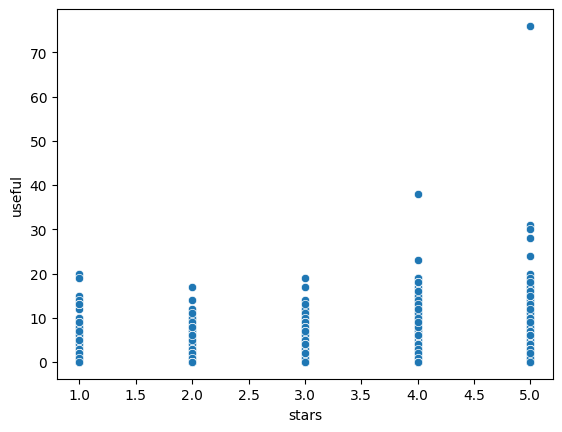

In [ ]:
sns.scatterplot(df_restaurants,
                x = 'stars',
                y = 'useful');

In [ ]:
mat_corr = df_restaurants[['useful', 'stars']].corr()

print(f"Le coefficient de corrélation est de {round(mat_corr['useful'].loc['stars'], 3)}. Il n'existe pas de corrélation entre les colonnes 'useful' et 'stars'. ")

Le coefficient de corrélation est de -0.023. Il n'existe pas de corrélation entre les colonnes 'useful' et 'stars'. 


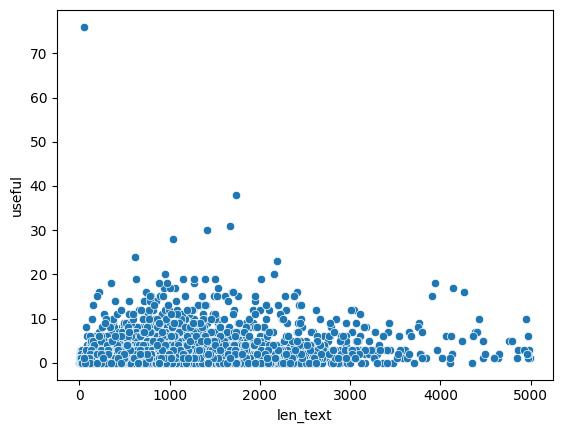

In [ ]:
sns.scatterplot(df_restaurants,
                x = 'len_text',
                y = 'useful');

In [ ]:
mat_corr2 = df_restaurants[['useful', 'len_text']].corr()

print(f"Le coefficient de corrélation est de {round(mat_corr2['useful'].loc['len_text'], 3)}. Il existe une très légère corrélation entre les colonnes 'useful' et 'stars'. ")

Le coefficient de corrélation est de 0.294. Il existe une très légère corrélation entre les colonnes 'useful' et 'stars'. 


# Partie 3: NLP - Classification d'analyse des sentiments - 2h

Définissez `X` qui ne contiendra que la colonne `text`et `y` qui sera la colonne `sentiment`.

In [ ]:
X = df_restaurants['text']
y = df_restaurants['sentiment']

## Créez une fonction pour nettoyer les mots d'arrêt et la ponctuation

Vous pouvez appeler votre fonction `func_clean`.
Votre fonction doit prendre un `str` en tant que paramètre unique et retourner un `str`.

Par exemple:

`func_clean("Hello, how are you? Fine, thank you.")`

`>>> 'hello fine thank'`

In [ ]:
def func_clean(text):

  tokens = nltk.word_tokenize(text.lower())

  tokens_clean = []
  for words in tokens:
    if words not in nltk.corpus.stopwords.words("english") and words.isalpha() == True:
      tokens_clean.append(words)

  str_tokens_clean = " ".join(tokens_clean)
  return str_tokens_clean

In [ ]:
func_clean("Hello, how are you? Fine, thank you.")

'hello fine thank'

## Appliquer cette fonction

Apply cette fonction à `X` et stockez le résultat dans la variable ` X_clean`.

In [ ]:
df_restaurants['X_clean'] = df_restaurants['text'].apply(lambda x : func_clean(x))

In [ ]:
df_restaurants['X_clean']

,X_clean
0,wife took birthday breakfast excellent weather...
1,idea people give bad reviews place goes show p...
2,love gyro plate rice good also dig candy selec...
3,rosie dakota love chaparral dog park convenien...
4,general manager scott petello good egg go deta...
...,...
9995,first visit lunch today used groupon ordered b...
9996,called house deliciousness could go item item ...
9997,recently visited olive ivy business last week ...
9998,nephew moved scottsdale recently bunch friends...


## Split de test de train

Divisez vos données `X_clean` et `y` avec un `train_test_split()`, et le même `random_state = 32`.

In [ ]:
X = df_restaurants['X_clean']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=32)

## tfidfvectorizer

- Initialiser votre vectorisateur et stockez le résultat dans `vectorizer`
- Train `vectorizer` sur ` x_train`.
- Train et Transform `x_train` avec votre vectorisateur et stockez le résultat dans `x_train_vecto`.
- Transformez `x_test` avec votre vectorisateur et stockez le résultat dans` x_test_vecto`.

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

x_train_vecto = vectorizer.transform(X_train)
x_test_vecto = vectorizer.transform(X_test)

## Régression logistique

Entrainer un modèle de régression logistique sur `x_train_vecto` et` y_train`.

Veuillez comparer les scores de précision des ensembles de formation et de test.Y a-t-il un sur-ajustement (`OverFitting)`?

Affichez également une matrice de confusion pour l'ensemble de tests.Combien de «mauvais» commentaires sont correctement prédits?

In [ ]:
lr = LogisticRegression().fit(x_train_vecto, y_train)

In [ ]:
print('Train score =', round(lr.score(x_train_vecto, y_train), 3))
print('Test score =', round(lr.score(x_test_vecto, y_test), 3))
print("Il n'y a pas d'overfitting dans ce modèle")

Train score = 0.895
Test score = 0.834
Il n'y a pas d'overfitting dans ce modèle


In [ ]:
mc = pd.DataFrame(data = confusion_matrix(y_true = y_test, y_pred = lr.predict(x_test_vecto)))
display(mc)
print(f"Au total, {mc[0].loc[0]} «mauvais» commentaires ont été correctement prédits.")

,0,1
0,427,327
1,88,1658


Au total, 427 «mauvais» commentaires ont été correctement prédits.


## Arbre de décision
Entrainer un modèle d'arbre de décision sur `x_train_vecto` et` y_train`.

Veuillez comparer les scores de précision des ensembles de formation et de test.Y a-t-il un sur-ajustement?Les scores sont-ils meilleurs qu'auparavant?

In [ ]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train_vecto, y_train)

In [ ]:
print('Train score =', round(clf.score(x_train_vecto, y_train), 3))
print('Test score =', round(clf.score(x_test_vecto, y_test), 3))
print("Il existe un overfitting dans ce modèle car le train score est égal à 1 et non le test score.")

Train score = 1.0
Test score = 0.706
Il existe un overfitting dans ce modèle car le train score est égal à 1 et non le test score.


## Comparaison des algorithmes

Comparer les scores des 2 algorithmes, intéprétez et dites-nous lequel est meilleur selon vous ?

In [ ]:
print('Régression Logistique')
print('Train score =', round(lr.score(x_train_vecto, y_train), 3))
print('Test score =', round(lr.score(x_test_vecto, y_test), 3))

print('\nArbre de Décision')
print('Train score =', round(clf.score(x_train_vecto, y_train), 3))
print('Test score =', round(clf.score(x_test_vecto, y_test), 3))

print("\nLe meilleur modèle semble être la régression logisitique car il n'y a pas d'overfitting \net les scores de Train et de test sont proches et élevés.")

Régression Logistique
Train score = 0.895
Test score = 0.834

Arbre de Décision
Train score = 1.0
Test score = 0.706

Le meilleur modèle semble être la régression logisitique car il n'y a pas d'overfitting 
et les scores de Train et de test sont proches et élevés.


## Question bonus (facultatif)

Utilisez `GRIDSEARCHCV` pour trouver les meilleurs paramètres.
Assurez-vous de ne pas faire plus de 1000 itérations différentes (c'est-à-dire des combinaisons).
Sinon, le temps peut sembler très long ...

In [ ]:
models = [
    LogisticRegression(),
    tree.DecisionTreeClassifier(),
]

param_grids = [
    {'C': [0.001, 0.01, 0.1, 1],
     'penalty': ['l1', 'l2', 'elasticnet']},
     {'max_depth': [3, 5, 10],
      'min_samples_split': [2, 5, 10],
      'criterion': ['gini', 'entropy'],
      'splitter' : ['best', 'random']}
              ]

In [ ]:
for model, param_grid in zip(models, param_grids):
    gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
    gs.fit(x_train_vecto, y_train)

    print(f"Meilleur score pour {model.__class__.__name__}: {gs.best_score_:.3f}")
    print(f"Meilleurs paramètres pour {model.__class__.__name__}: {gs.best_params_}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/us

Meilleur score pour LogisticRegression: 0.818
Meilleurs paramètres pour LogisticRegression: {'C': 1, 'penalty': 'l2'}
Meilleur score pour DecisionTreeClassifier: 0.715
Meilleurs paramètres pour DecisionTreeClassifier: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10, 'splitter': 'random'}


# Optionnel: algorithme `json` et manipulation.
Il s'agit d'un fichier JSON contenant plusieurs clés.
Chaque clé a une valeur, qui pourrait potentiellement être une autre clé, contenant une autre valeur, qui pourrait potentiellement être une autre clé, etc.

In [ ]:
food = {
  "clé1": {
    "fruit1": "pomme",
    "légume4": "brocoli"
  },
  "clé2": {
    "légume1": "carotte",
    "fruit5": "banane",
    "légume3": "courgette"
  },
  "clé3": {
    "niveau1": {
      "niveau2": {
        "fruit3": "orange",
        "légume5": "aubergine",
        "fruit5": "mangue"
      }
    }
  },
  "clé4": {
    "niveau1": {
      "niveau2": {
        "niveau3": {
          "fruit6": "raisin",
          "fruit7": "fraise",
          "légume4": "poivron",
          "fruit2": "pastèque"
        }
      }
    }
  }
}


Problème:
Les fruits et légumes ont été égarés dans ce fichier JSON.L'objectif est de récupérer chacun des fruits et légumes et de les attribuer à deux listes correspondantes: `Fruits_list` &` LEGETALS_LIST`.

Solution attendue:

`fruits_list` = `['pomme', 'banane', 'orange', 'mangue', 'raisin', 'fraise', 'pastèque']`

`vegetables_list` = `['brocoli', 'carotte', 'courgette', 'aubergine', 'poivron']`


In [ ]:
fruits_list = []
vegetables_list = []

def ajout_list(dico, fruits_list, vegetables_list):
    for element in dico:
      if 'fruit' in element:
        fruits_list.append(dico[element])
      else:
        vegetables_list.append(dico[element])

    return fruits_list, vegetables_list

In [ ]:
fruits_list, vegetables_list = ajout_list(food['clé1'], fruits_list, vegetables_list)
fruits_list, vegetables_list = ajout_list(food['clé2'], fruits_list, vegetables_list)
fruits_list, vegetables_list = ajout_list(food['clé3']['niveau1']['niveau2'], fruits_list, vegetables_list)
fruits_list, vegetables_list = ajout_list(food['clé4']['niveau1']['niveau2']['niveau3'], fruits_list, vegetables_list)

In [ ]:
fruits_list

['pomme', 'banane', 'orange', 'mangue', 'raisin', 'fraise', 'pastèque']

In [ ]:
vegetables_list

['brocoli', 'carotte', 'courgette', 'aubergine', 'poivron']

Ensuite, vous créerai un nouveau dictionnaire, qui contiendra simplement deux clés: «fruits» et «légumes».Chaque clé aura la valeur de la liste des fruits et la liste des légumes.De cette façon, tout sera en ordre.

Solution attendue:

`food_dict` = `{'fruits': ['pomme','banane','orange','mangue','raisin','fraise','pastèque'],
 'legumes': ['brocoli', 'carotte', 'courgette', 'aubergine', 'poivron']}`

In [ ]:
food_dict = {'fruits': fruits_list,
             'legumes': vegetables_list}

In [ ]:
food_dict

{'fruits': ['pomme',
  'banane',
  'orange',
  'mangue',
  'raisin',
  'fraise',
  'pastèque'],
 'legumes': ['brocoli', 'carotte', 'courgette', 'aubergine', 'poivron']}